In [1]:
using LinearAlgebra, DifferentialEquations, Statistics
import PyPlot
Plt = PyPlot;

# Theoretical Results

In [2]:
"`N`, the initial monomer mass."
N = 1.0

"`Eg`, Gibbs free energy of bond formation."
Eg = -1.5

Eg

In [3]:
"`R`, the universal gas constant."
const R = 2e-3

"""
`T`, the Kelvin temperature. Chosen for consistency 
with experiments by Rajamani (2008) and DeGuzman (2014)
as well as the simulation treatment of Ross (2016).
"""
T = 85 + 273.16

"""
`α₋`, the rate at which RNA bonds hydrolyze. Observed 
experimentally by Oivanen (1998) at a similar temperature
in a highly acidic environment.
"""
α₋ = 1e-6

"""
    α₊(α₋, ΔG, N)

Calculates the synthesis rate constant for a given hydrolysis
rate, free energy of bond formation and total concentration of
monomer units.
"""
α₊(α₋, ΔG, N) = α₋/N * ℯ^(-ΔG / R/T) * (1 + ℯ^(-ΔG / R/T))

"""
    ΔG(Pb)

Calculates the free energy which will produce a desired
bonding probability according to Boltzmann statistics.
"""
ΔG(Pb) = -R*T * log(Pb / (1 - Pb))

"""
    Pb(ΔG)

Calculates the bonding probability Pb from a known ΔG using
Boltzmann statistics. 
"""
Pb(ΔG) = 1 / (1 + ℯ^(ΔG / R/T))

"""
    Pb(α₋, α₊, N)

Calculates the bonding probability for a provided hydrolysis
rate and synthesis rate constant.
"""
function Pb(α₋, α₊, N) 
    a = α₋/α₊/2/N
    return 1 + a - √(a * (2 + a))
end

Pb

# The Analytical Solution

In [4]:
"""
    ṗ(p, (N, α₋, α₊), t)

For a length distribution which is Flory-Schulz
but doesn't match the steady-state value of Pb,
calculate the time derivative of the distribution
parameter p. The unique fixed point of this ODE 
is stable and occurs at Pb(α₋, α₊, N).
"""
ṗ(p, (α₋, α₊, N), t) = N*α₊*(1 - p)^2  -  α₋*p


"""
    p_analytical(p0, (α₋, α₊, N), t)

For a length distribution which is initially Flory-Schulz
but with an incorrect parameter p0, computes the analytical 
solution as a function of time.
"""
function p_analytical(p0, (α₋, α₊, N), t)
    a = α₋ / α₊ / 2/N
    Δ = √(a*(a+2))
    c = atanh((1 + a - p0)/Δ + 0im)
    return @. real(1 + a - Δ*tanh(c + Δ*α₊*N*t))
end

p_analytical

# Numerical Simulation

In [5]:
"""
    ṅ(n, (α₋, α₊), t)

Derivative of a vector of concentrations nₖ of 
k-mers in our solution, where bonds hydrolyse 
at a rate α₋ and bonds form at a rate α₊ ∑nₖ.

An implementation of the rate equations derived 
from a family of reaction equations suggested 
by Ross and Deamer (2016), which describe the
synthesis and hydrolysis of polymers like this:

    nₖ + nⱼ ⇄ nₖ₊ⱼ

The system is time-invariant, so the time 
argument t is ignored.
"""
function ṅ(n, (α₋, α₊), t)
    d = length(n)
    dn = zero(n) ./ oneunit(t)
    
    for k in 1:d
        dn[k] -= 2α₊ * n[k] * sum(n[1:d-k])
        dn[k] += 2α₋ * sum(n[k+1:d])
        dn[k] += α₊ * sum(n[1:k-1] .* n[k-1:-1:1])
        dn[k] -= α₋ * (k-1) * n[k]
    end
    
    return dn
end



"""
    monomers(N, d)

Generates a state vector representing the condition where
there is a concentration N of monomers and all other k-mers
are absent, for simulations with maximum polymer length d.
"""
function monomers(N, d)
    n = oneunit(N) .* zeros(d)
    n[1] = N
    return n
end


"""
    p_dynamics(tmax, α₋, α₊, N, p0)

Solves the dynamics of the parameter of a Flory-Schulz distribution
with initial value p0, total monomer unit concentration N, hydrolysis 
rate α₋, and synthesis rate constant α₊. 
"""
function p_dynamics(tmax, α₋, α₊, N, p0; abstol=1e-10, reltol=1e-10)
    prob = ODEProblem(ṗ, p0, tmax, (α₋, α₊, N))
    solve(prob, abstol=abstol, reltol=reltol)
end


"""
    dynamics(tmax, α₋, α₊, n₀)

Solves the dynamics from an initial condition n₀ until
an end time tmax, with hydrolysis rate α₋ and synthesis
rate constant α₊. The truncation length is inferred from
the dimension of n₀.
"""
function dynamics(tmax, α₋, α₊, n₀; abstol=1e-10, reltol=1e-10)
    prob = ODEProblem(ṅ, n₀, tmax, (α₋, α₊))
    solve(prob, Rosenbrock23(), abstol=abstol, reltol=reltol)
end

steadystate

# Truncation

In [6]:
"""
    n∞(Pb, N, d)

Calculates the analytical steady-state distribution of 
polymer lengths, truncated to a maximum length of d.
"""
n∞(Pb, N, d) = @. (1-Pb)^2 * N * Pb ^ (0:d-1)


"""
    mass(n̂)

Calculates the total mass of polymers in a finite-length
solution n̂, in units of monomer mass.
"""
mass(n̂) = sum((1:length(n̂)) .* n̂)

"""
    error(n̂, Pb, N)

Calculates the ℓ² error between a finite-dimensional 
approximation n̂ and the infinite-dimensional solution 
to the problem with known Pb and N.

This includes a term for the ℓ² norm of the infinite 
tail of polymers greater than the truncation length,
which is implicitly zero in n̂.
"""
function error(n̂, Pb, N)
    d = length(n̂)
    n = n∞(Pb, N, d)
    
    # Truncation error. This is equal to the ℓ² distance
    # between the correct solution and its truncation,
    # computed as the square root of sum of squares of
    # nₖ for k from d+1 to ∞.
    tailerror = (1-Pb)^2 * N * Pb^d / √(1 - Pb^2)
    
    return √(tailerror^2 + norm(n - n̂)^2)
end

"""
    errorbound(Pb, d)

Calculates the minimum possible relative ℓ² error of  
any mass-preserving truncation to maximum length d of 
the polymerization dynamics for bonding probability Pb.

This bound is exactly the ℓ² distance between the 
analytical solution and the set of polymer distributions
with maximum length d and total mass N, divided by the 
ℓ² norm of the analytical solution.
"""
function errorbound(Pb, d)
    m̂ = (1 + (1-Pb)d) * Pb^d
    normy = (1-Pb)^2 / √(1 - Pb^2)
    mass_error = m̂ / norm(1:d) / normy
    tail_error = Pb^d
    return √(mass_error^2 + tail_error^2)
end

errorbound

# Thermodynamical Figures

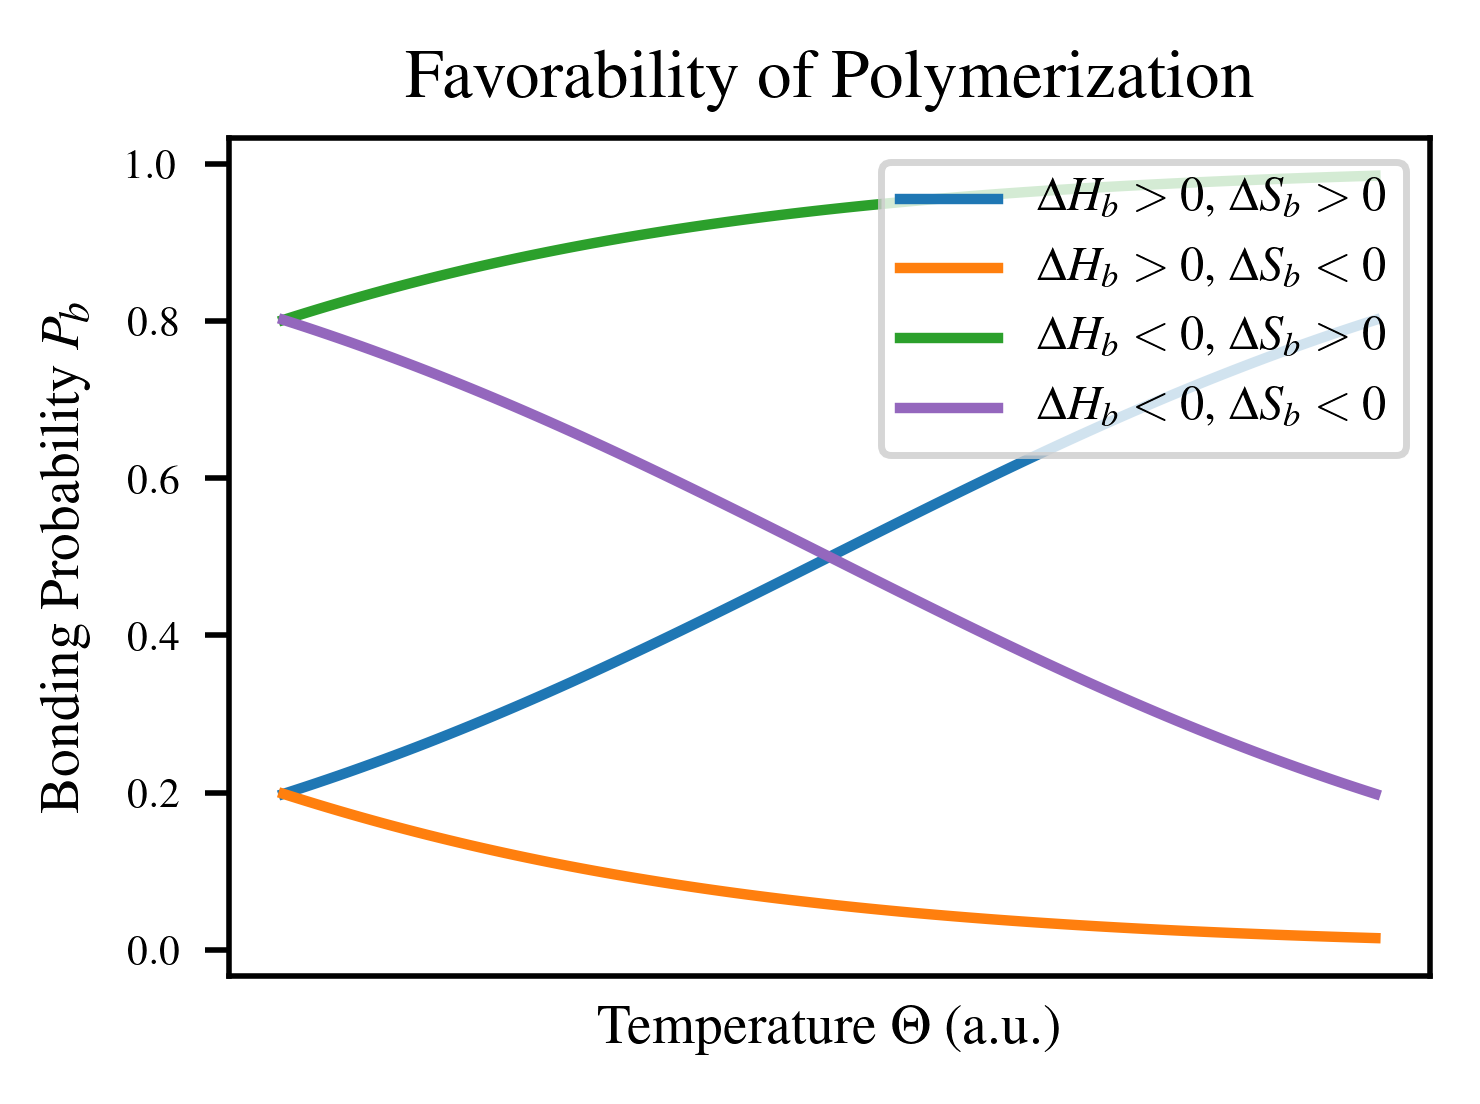

In [8]:
# Nondimensional enthalpy and entropy of bond formation
# for a toy example.
ΔHs = [1, -1]
ΔSs = [1, -1]
Θ = range(0,2; length=100)

f = Plt.figure()
ax = f.gca()
# ax.axhline(0.5; ls=":", c="k")
ax.plot(Θ, Pb.(ΔHs[1] .- Θ*ΔSs[1]), label=raw"$\Delta H_b > 0$, $\Delta S_b > 0$")
ax.plot(Θ, Pb.(ΔHs[1] .- Θ*ΔSs[2]), label=raw"$\Delta H_b > 0$, $\Delta S_b < 0$")
ax.plot(Θ, Pb.(ΔHs[2] .- Θ*ΔSs[1]), label=raw"$\Delta H_b < 0$, $\Delta S_b > 0$")
ax.plot(Θ, Pb.(ΔHs[2] .- Θ*ΔSs[2]), "C4", label=raw"$\Delta H_b < 0$, $\Delta S_b < 0$")

ax.set_title(raw"Favorability of Polymerization")
ax.set_xlabel(raw"Temperature $\Theta$ (a.u.)")
ax.set_xticks([])
ax.set_ylabel(raw"Bonding Probability $P_b$")
ax.legend(loc=1)

# Figures for Analytical Solution

In [9]:
t = 10 .^ range(-1,7; length=100)
panal(t) = p_analytical(0.0, (α₋, α₊(α₋, Eg, N), N), t)

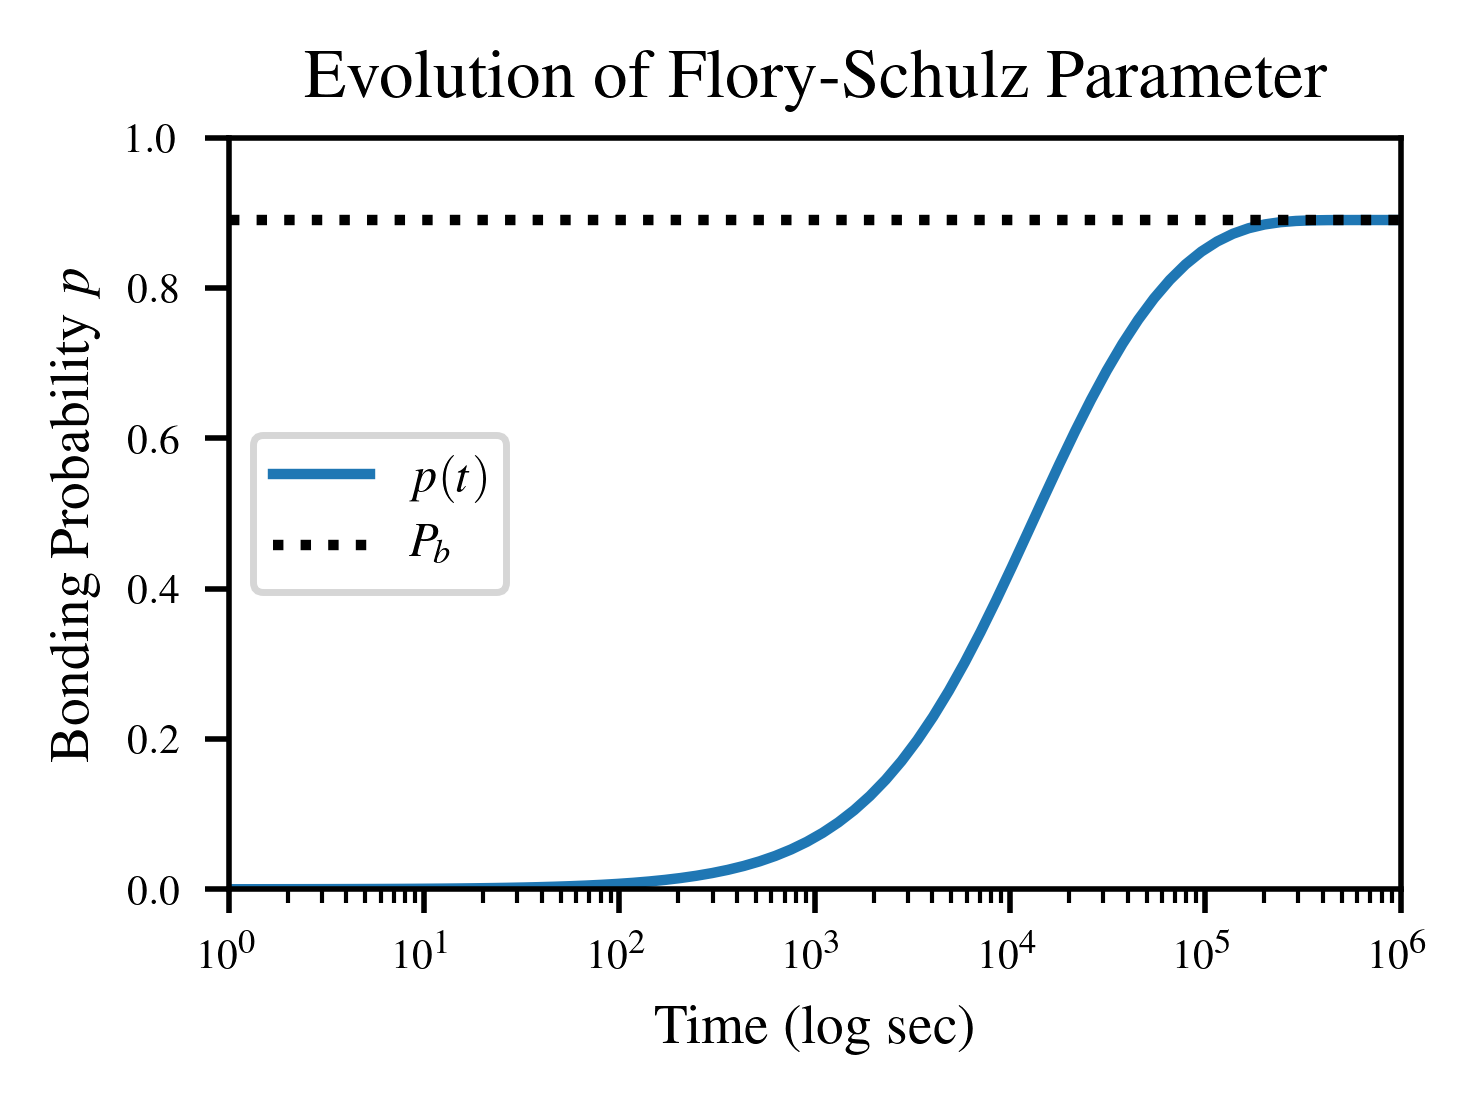

In [10]:
f = Plt.figure()
ax = f.gca()
ax.semilogx(t, panal(t), label=raw"$p(t)$")
ax.axhline(Pb(Eg); linestyle=":", color="k", label=raw"$P_b$")
ax.legend(loc=6)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(0,1)
ax.set_xlabel(raw"Time (log sec)")
ax.set_ylabel(raw"Bonding Probability $p$")
ax.set_title(raw"Evolution of Flory-Schulz Parameter")

In [11]:
@time d10 = dynamics(t[end], α₋, α₊(α₋, Eg, N), monomers(N,10));

  8.209618 seconds (21.82 M allocations: 1.281 GiB, 8.66% gc time)


In [12]:
@time d25 = dynamics(t[end], α₋, α₊(α₋, Eg, N), monomers(N,25));

  3.423518 seconds (8.54 M allocations: 4.526 GiB, 26.30% gc time)


In [13]:
@time d50 = dynamics(t[end], α₋, α₊(α₋, Eg, N), monomers(N,50));

 20.085418 seconds (18.97 M allocations: 46.312 GiB, 52.75% gc time)


In [14]:
@time d100 = dynamics(t[end], α₋, α₊(α₋, Eg, N), monomers(N,100));

356.222842 seconds (68.47 M allocations: 578.852 GiB, 26.34% gc time)


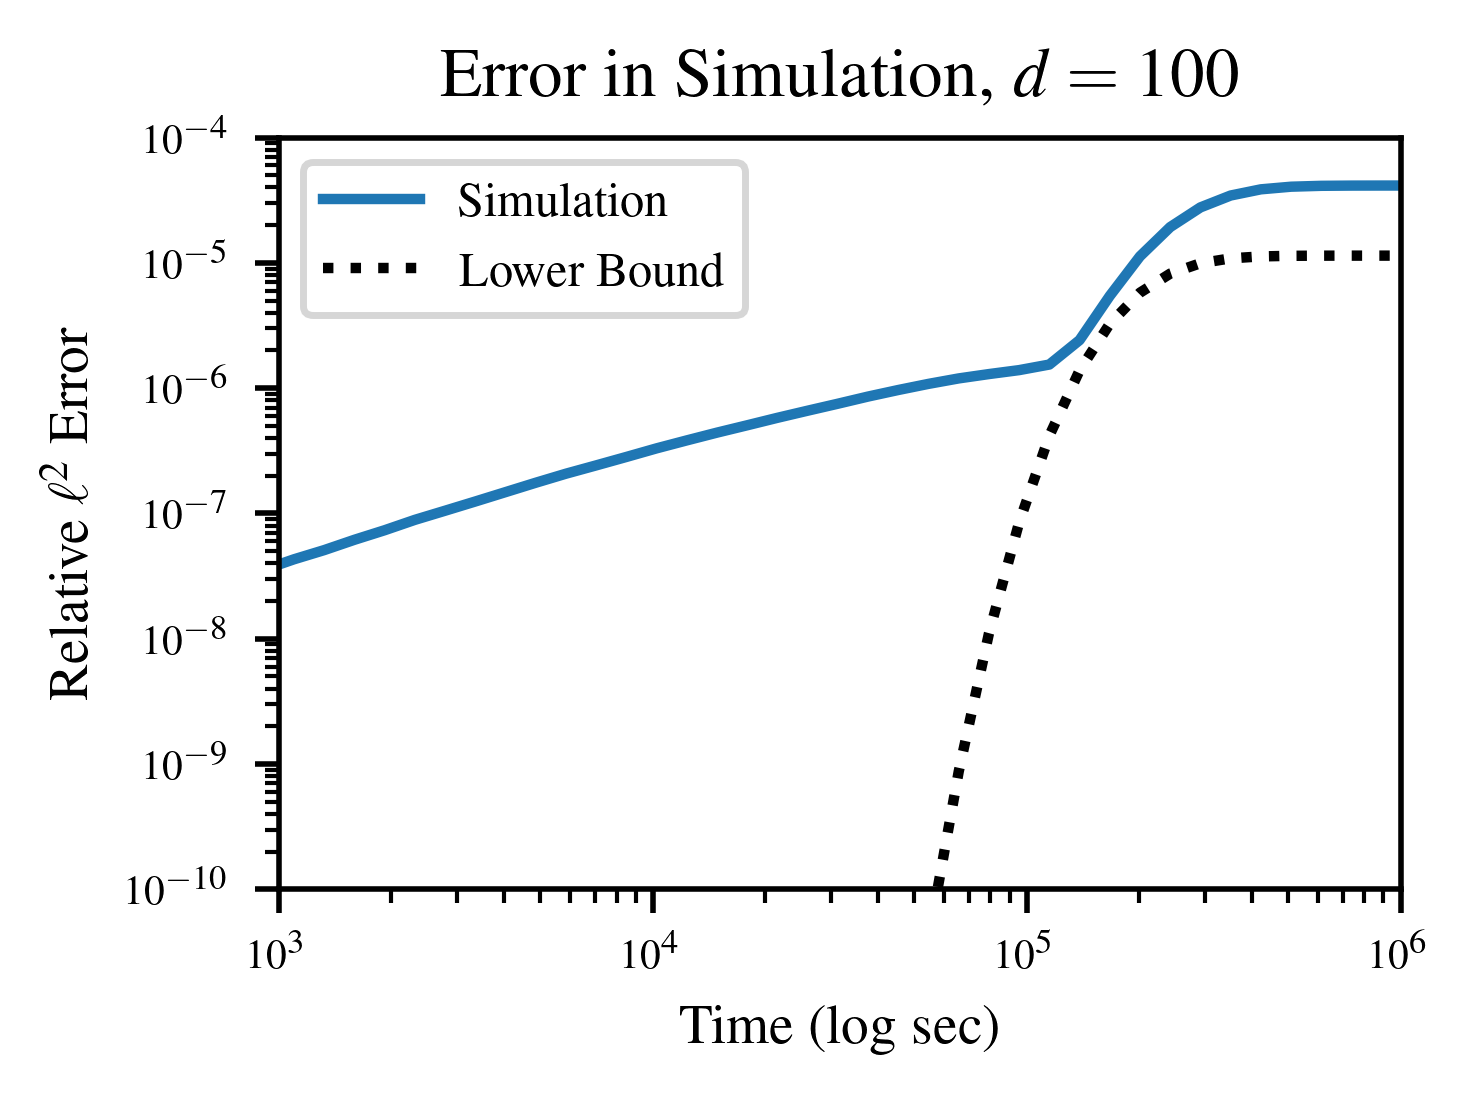

In [15]:
f = Plt.figure()
ax = f.gca()

normy = @. (1-panal(t))^2 * N / √(1 - panal(t)^2)

ax.loglog(t, error.(d100.(t), panal.(t), N) ./ normy; label=raw"Simulation")
ax.loglog(t, errorbound.(panal.(t), 100), "k:"; label="Lower Bound")

ax.legend()
ax.set_xlim(1e3, 1e6)
ax.set_ylim(1e-10, 1e-4)
ax.set_xlabel(raw"Time (log sec)")
ax.set_ylabel(raw"Relative $\ell^2$ Error")
ax.set_title(raw"Error in Simulation, $d=100$")

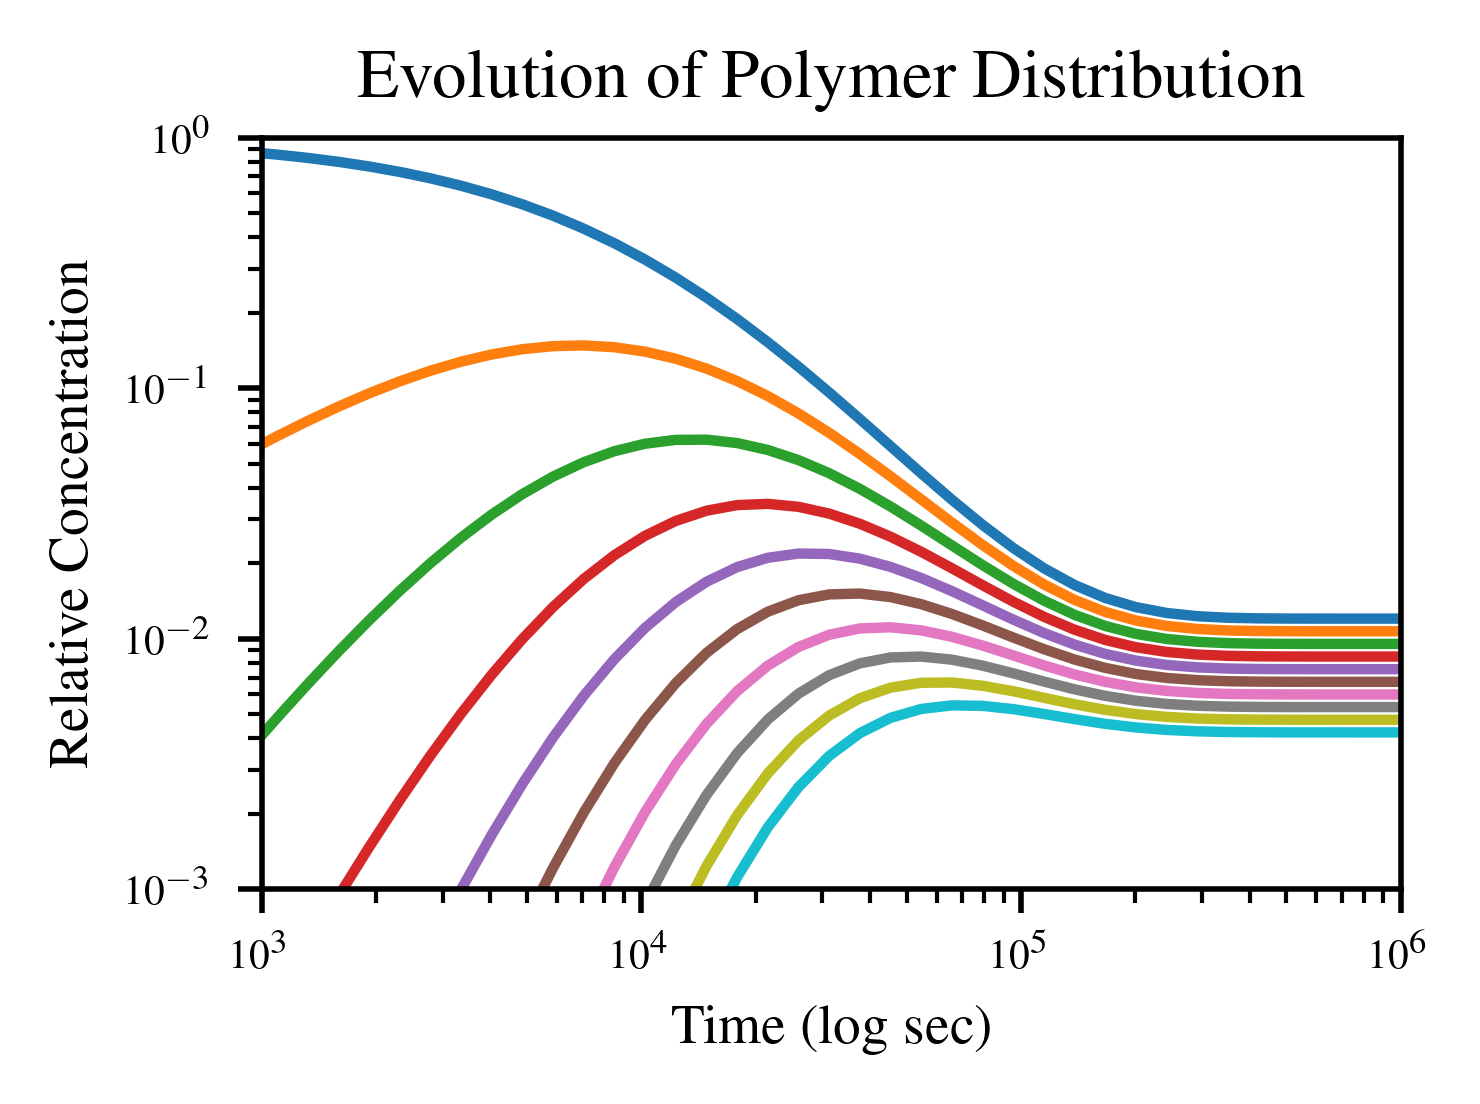

In [16]:
f = Plt.figure()
ax = f.gca()
ax.loglog(t, n∞.(panal(t), N, 10)/N)
ax.set_ylim(1e-3, 1)
ax.set_xlim(1e3, 1e6)
ax.set_xlabel("Time (log sec)")
ax.set_ylabel("Relative Concentration")
ax.set_title(raw"Evolution of Polymer Distribution")

# Truncated Numerical Solution

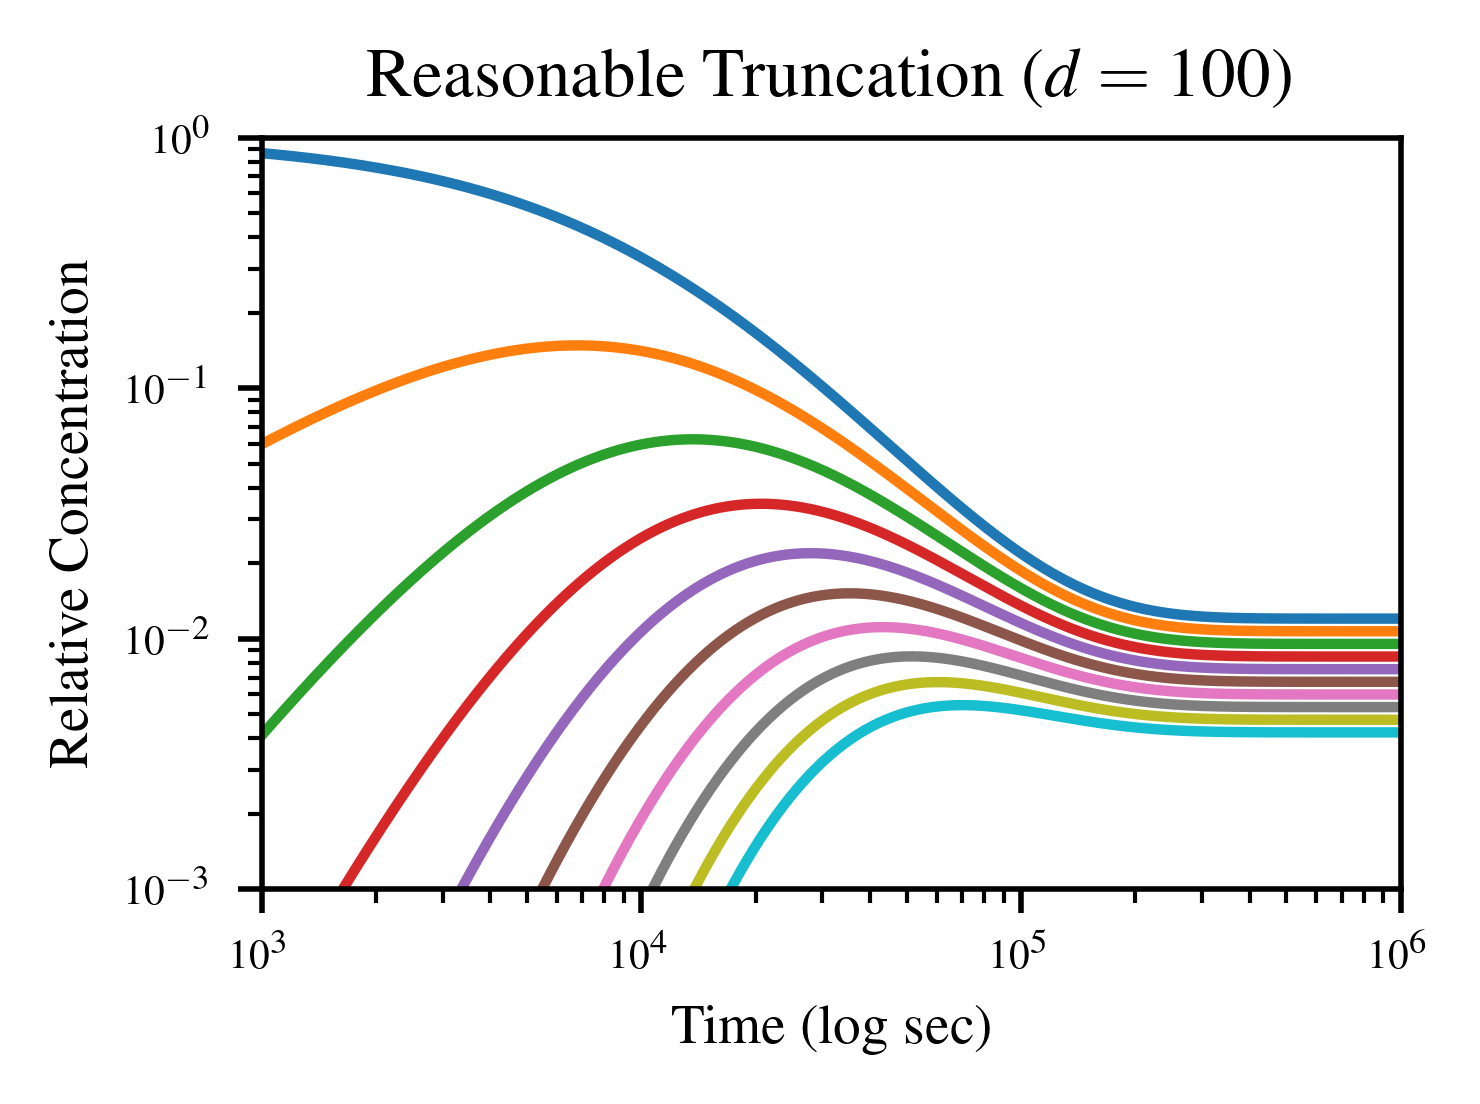

In [17]:
f = Plt.figure()
ax = f.gca()
ax.loglog(d100.t, [u[1:10] for u in d100.u] ./ N)
ax.set_ylim(1e-3, 1) 
ax.set_xlim(1e3, 1e6)
ax.set_xlabel("Time (log sec)")
ax.set_ylabel("Relative Concentration")

f.gca().set_title(raw"Reasonable Truncation ($d=100$)")

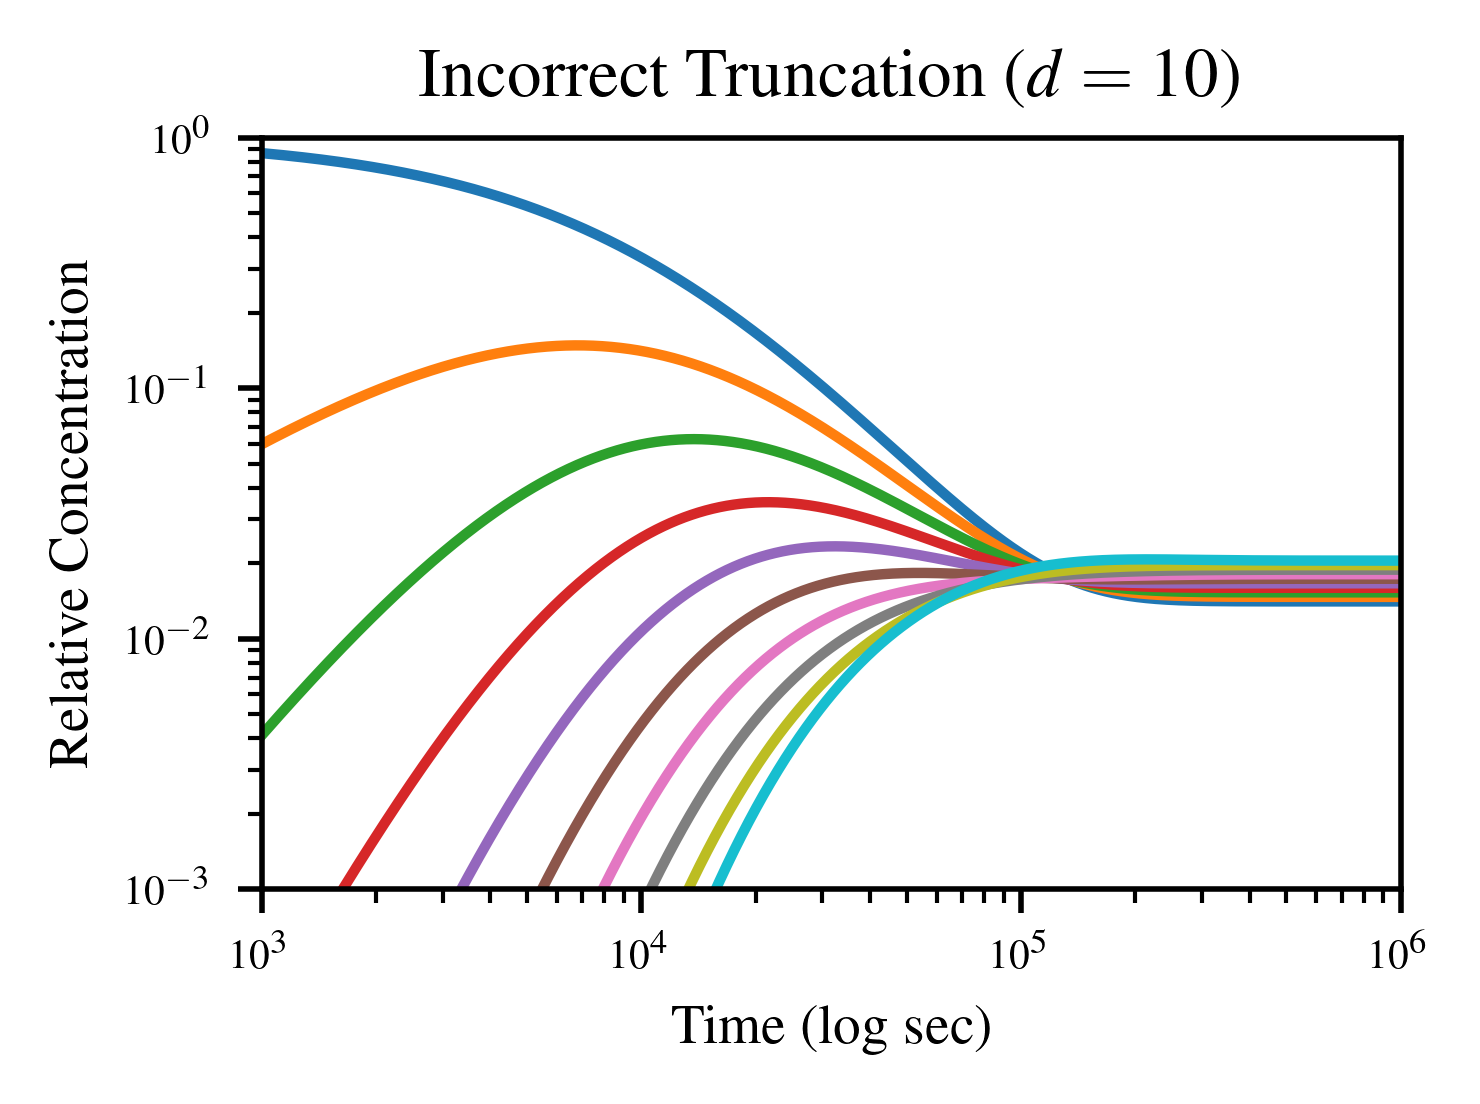

In [18]:
f = Plt.figure()
ax = f.gca()
ax.loglog(d10.t, d10.u/N)
ax.set_ylim(1e-3, 1) 
ax.set_xlim(1e3, 1e6)
ax.set_xlabel("Time (log sec)")
ax.set_ylabel("Relative Concentration")

f.gca().set_title(raw"Incorrect Truncation ($d=10$)")

# Polymer Mass Distribution

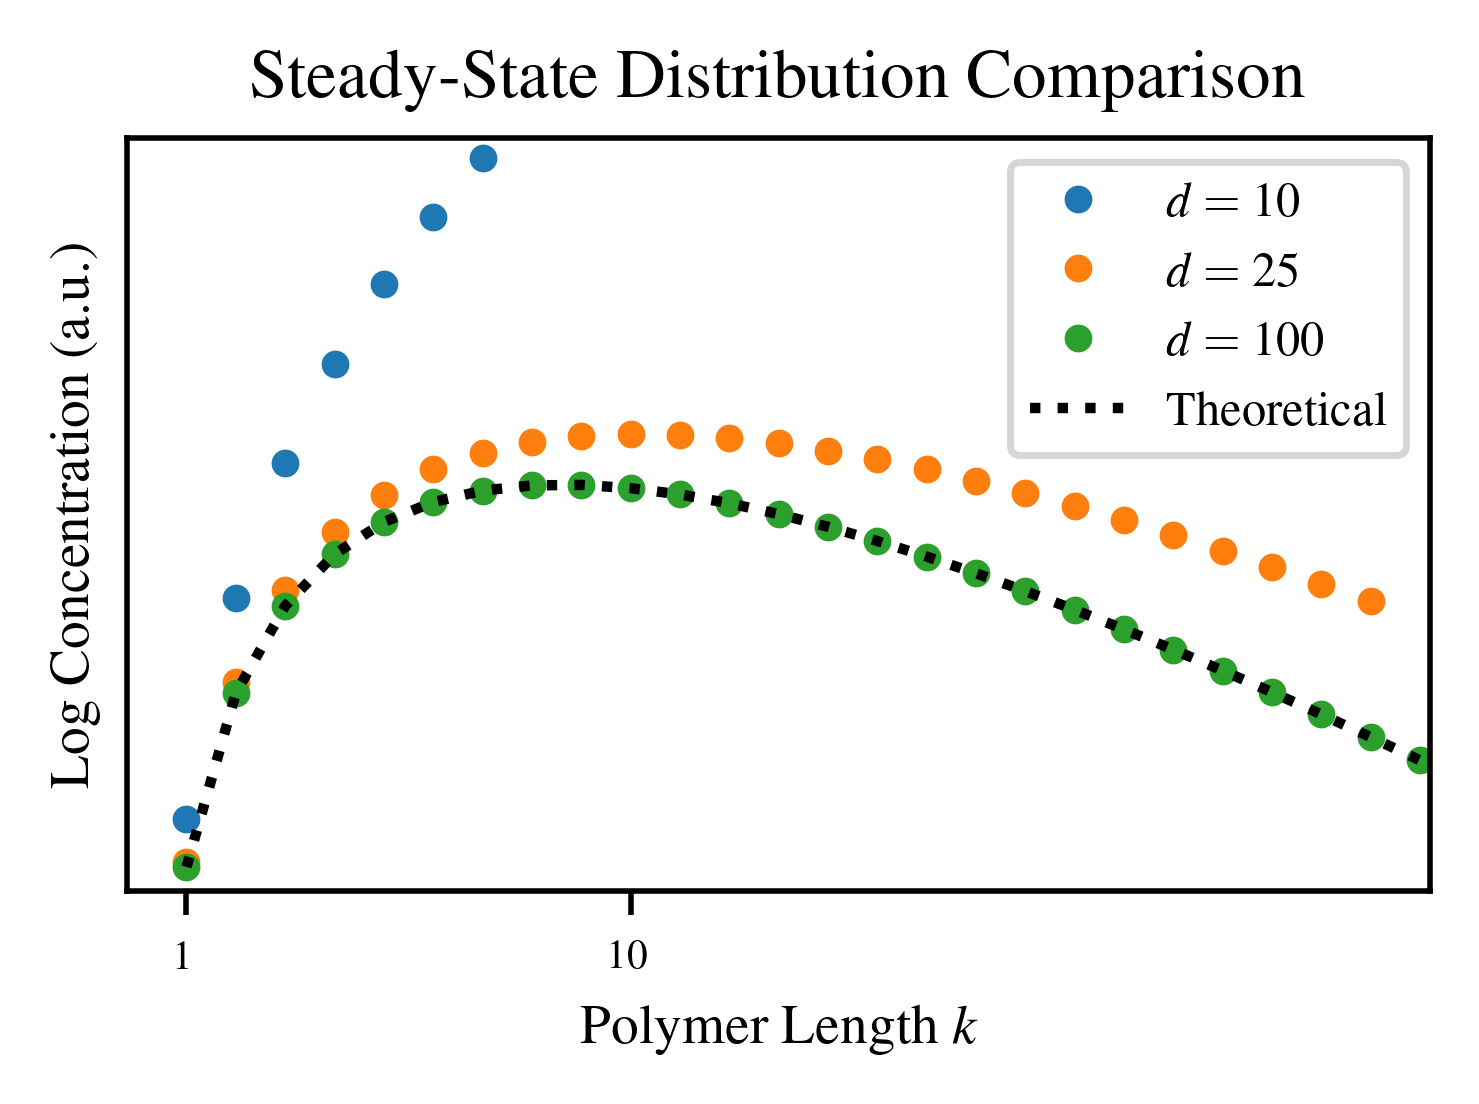

In [19]:
f = Plt.figure()
ax = f.gca()
ax.plot(1:10, log.((1:10) .* d10.u[end]), "."; label=raw"$d=10$")

ax.plot(1:25, log.((1:25) .* d25.u[end]), "."; label=raw"$d=25$")
xlim = ax.get_xlim()
ax.plot(1:100, log.((1:100) .* d100.u[end]), "."; label=raw"$d=100$")
ax.plot(1:100, log.((1:100) .* n∞(Pb(Eg), N, 100)), "k:"; label="Theoretical")
ax.set_xlim(xlim)
ax.set_ylim(-4.5,-2)
ax.legend(loc=0)
ax.set_xticks([1, 10])
ax.set_yticks([])
ax.set_xlabel(raw"Polymer Length $k$")
ax.set_ylabel(raw"Log Concentration (a.u.)")
ax.set_title("Steady-State Distribution Comparison")
;

# Polymer Length Distribution

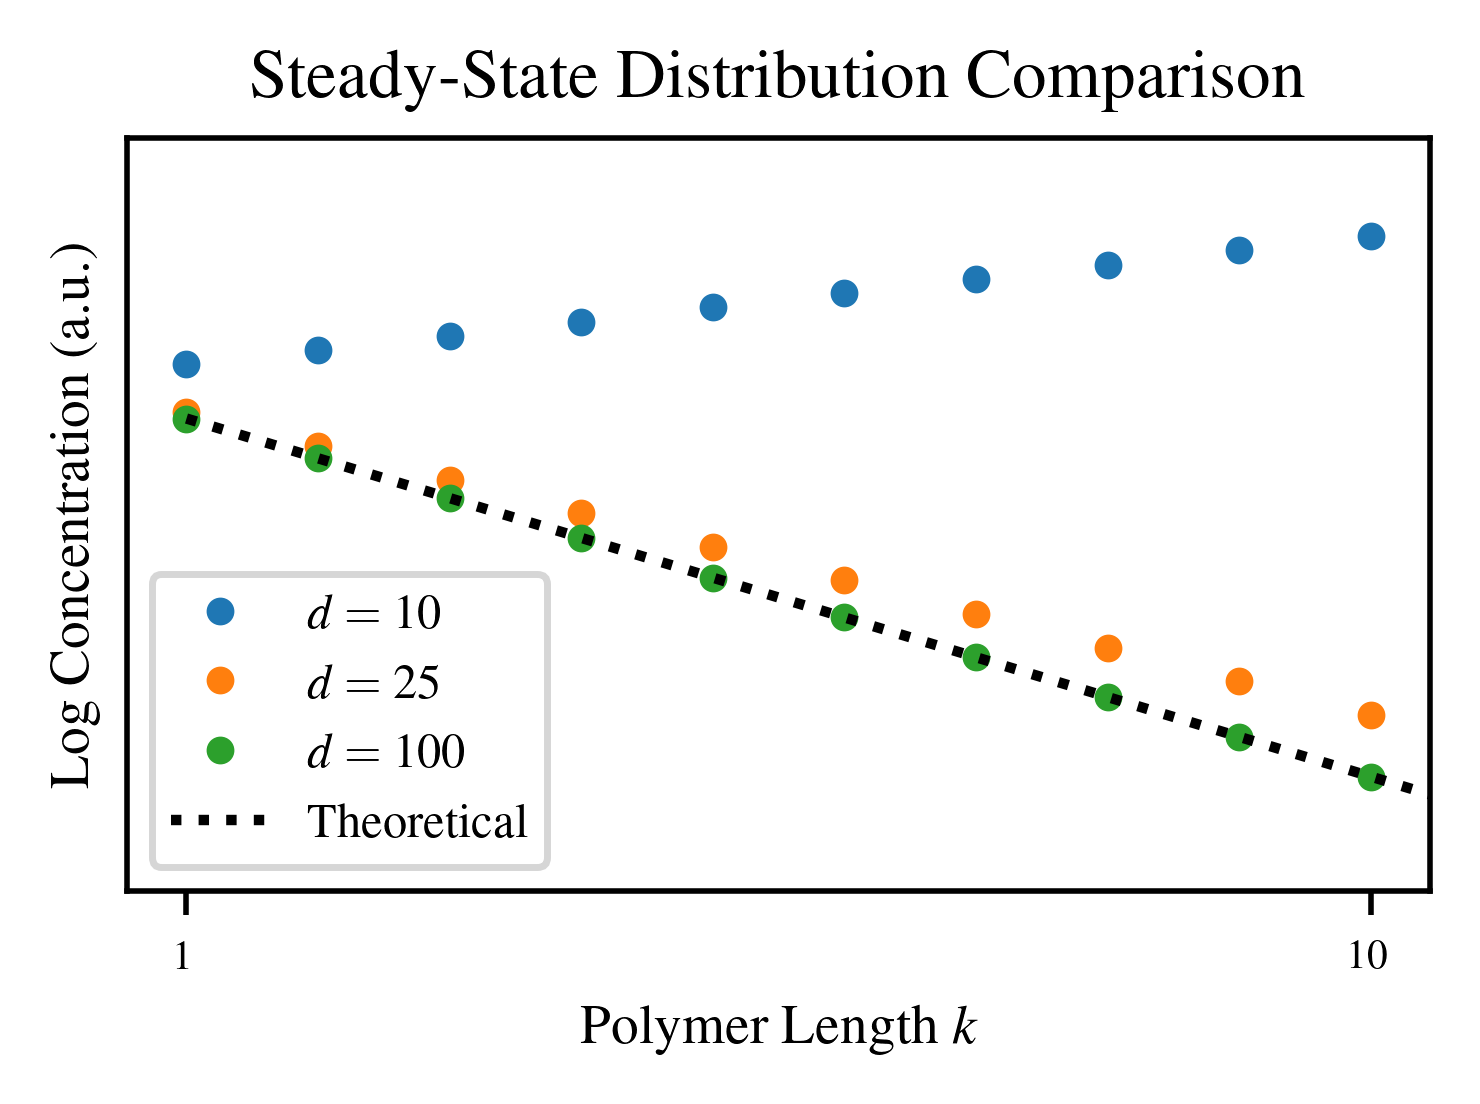

In [20]:
f = Plt.figure()
ax = f.gca()
ax.plot(1:10, log.(d10.u[end]), "."; label=raw"$d=10$")
xlim = ax.get_xlim()
ax.plot(1:25, log.(d25.u[end]), "."; label=raw"$d=25$")
ax.plot(1:100, log.(d100.u[end]), "."; label=raw"$d=100$")
ax.plot(1:100, log.(n∞(Pb(Eg), N, 100)), "k:"; label="Theoretical")
ax.set_xlim(xlim)
ax.set_ylim(-5.8,-3.6)
ax.legend(loc=0)
ax.set_xticks([1, 10])
ax.set_yticks([])
ax.set_xlabel(raw"Polymer Length $k$")
ax.set_ylabel(raw"Log Concentration (a.u.)")
ax.set_title("Steady-State Distribution Comparison")
;